In [1]:
# ! pip install huggingface_hub
# ! pip install diffusers
# ! pip install datasets
# ! pip install accelerate
%%capture
# !sudo apt -qq install git-lfs
# ! pip install diffusers[training]==0.11.1 --upgrade

UsageError: Line magic function `%%capture` not found.


In [2]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%%capture
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [5]:
import torch

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"GPU: {device_name}")
else:
    print("No GPU available.")


GPU: NVIDIA GeForce RTX 3080


In [6]:
from dataclasses import dataclass

# 훈련 설정을 담고 있는 데이터 클래스를 정의합니다.
@dataclass
class TrainingConfig:
    image_size = 128  # 생성된 이미지의 해상도를 나타냅니다.
    train_batch_size = 8  # 훈련 배치 크기입니다.
    eval_batch_size = 8  # 평가 시 사용할 이미지의 샘플 개수입니다.
    num_epochs = 1000  # 훈련 에포크 수입니다.
    gradient_accumulation_steps = 1  # 그래디언트 누적 단계 수입니다.
    learning_rate = 1e-4  # 학습률입니다.
    lr_warmup_steps = 500  # 학습률 웜업 스텝 수입니다.
    save_image_epochs = 10  # 이미지를 저장할 에포크 간격입니다.
    save_model_epochs = 50  # 모델을 저장할 에포크 간격입니다.
    mixed_precision = 'fp16'  # 부동소수점 정밀도입니다. 'no'는 float32, 'fp16'은 자동 혼합 정밀도를 나타냅니다.
    output_dir = 'ddpm-butterflies-128'  # 로컬과 HF Hub에 모델 이름을 나타냅니다.

    push_to_hub = True  # 저장된 모델을 HF Hub에 업로드할지 여부를 나타냅니다.
    hub_private_repo = False  # HF Hub에 비공개 저장소로 업로드할지 여부를 나타냅니다.
    overwrite_output_dir = True  # 노트북을 다시 실행할 때 이전 모델을 덮어쓸지 여부를 나타냅니다.
    seed = 0  # 시드값입니다.

# TrainingConfig 클래스의 인스턴스를 생성합니다.
config = TrainingConfig()


In [7]:
from datasets import load_dataset

# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split="train")



# 데이터셋 이름을 "imagefolder"로 설정합니다.
config.dataset_name = "imagefolder"

# "imagefolder" 데이터셋을 "./train/" 디렉토리에서 로드합니다.
dataset = load_dataset(config.dataset_name, data_dir="./train/")


Resolving data files:   0%|          | 0/478 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/chwo6/.cache/huggingface/datasets/imagefolder/default-f98835a59bc6328c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 478
    })
})

In [9]:
from torchvision import transforms

# 이미지 전처리 파이프라인을 정의합니다.
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # 이미지 크기를 원하는 크기로 조정합니다.
        transforms.RandomHorizontalFlip(),  # 랜덤하게 이미지를 수평으로 뒤집습니다.
        transforms.ToTensor(),  # 이미지를 텐서로 변환합니다.
        transforms.Normalize([0.5], [0.5]),  # 이미지를 정규화(normalization)합니다. 평균과 표준편차로 정규화합니다.
    ]
)


In [10]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [11]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [12]:
from diffusers import UNet2DModel

# UNet2DModel 생성
model = UNet2DModel(
    sample_size=config.image_size,  # 원하는 이미지 해상도 (대상 이미지 해상도)
    in_channels=3,  # 입력 채널 수, RGB 이미지의 경우 3
    out_channels=3,  # 출력 채널 수, 출력 이미지의 채널 수
    layers_per_block=2,  # 각 UNet 블록에 사용할 ResNet 레이어 수
    block_out_channels=(128, 128, 256, 256, 512, 512),  # 각 UNet 블록의 출력 채널 수
    down_block_types=(
        "DownBlock2D",  # 일반적인 ResNet 다운샘플링 블록
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # 공간적 자기-주의를 갖는 ResNet 다운샘플링 블록
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # 일반적인 ResNet 업샘플링 블록
        "AttnUpBlock2D",  # 공간적 자기-주의를 갖는 ResNet 업샘플링 블록
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)


In [13]:
# ! pip install torch --upgrade

Resolving data files:   0%|          | 0/478 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/chwo6/.cache/huggingface/datasets/imagefolder/train-ada41ff6aa74c80a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Input shape: torch.Size([1, 3, 423, 640])


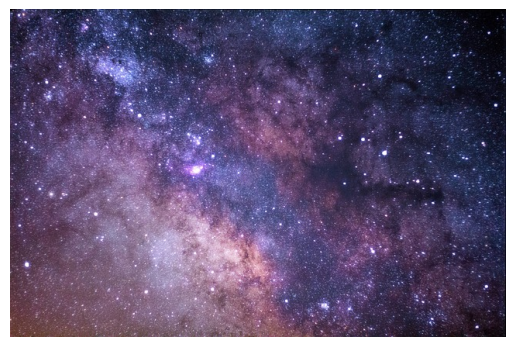

In [14]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# 데이터셋을 로드할 때, "train" 분할을 명시적으로 선택합니다.
# 실제로 사용하는 데이터셋에 따라 분할 값을 변경해주세요.
dataset = load_dataset('./train/', split='train')

# 이하 코드는 변경합니다.
sample_image = dataset[0]['image']

# 이미지 데이터를 bytes-like object 형태로 변환
sample_image_bytes = sample_image.tobytes()

# bytes-like object 형태의 이미지 데이터를 PIL 이미지 객체로 변환
pil_image = Image.frombytes('RGB', sample_image.size, sample_image_bytes)

# torchvision.transforms.ToTensor()를 사용하여 이미지를 Tensor로 변환
transform = transforms.ToTensor()
sample_image_tensor = transform(pil_image).unsqueeze(0)

print('Input shape:', sample_image_tensor.shape)

# Tensor를 이미지로 다시 변환하여 시각화
plt.imshow(sample_image_tensor[0].permute(1, 2, 0))
plt.axis('off')
plt.show()


In [15]:
# !pip install matplotlib

In [16]:
from torchvision import transforms

# 이미지 데이터 전처리 과정 정의
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # 이미지 크기를 (config.image_size, config.image_size)로 조정합니다.
        transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 좌우로 뒤집습니다. 데이터 증강을 위해 사용됩니다.
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환합니다.
        transforms.Normalize([0.5], [0.5]),  # 이미지의 픽셀 값을 정규화합니다. 픽셀 값을 -1에서 1 사이로 정규화합니다.
    ]
)


In [17]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

C:\Users\chwo6\AppData\Local\Temp\ipykernel_5660\948138263.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


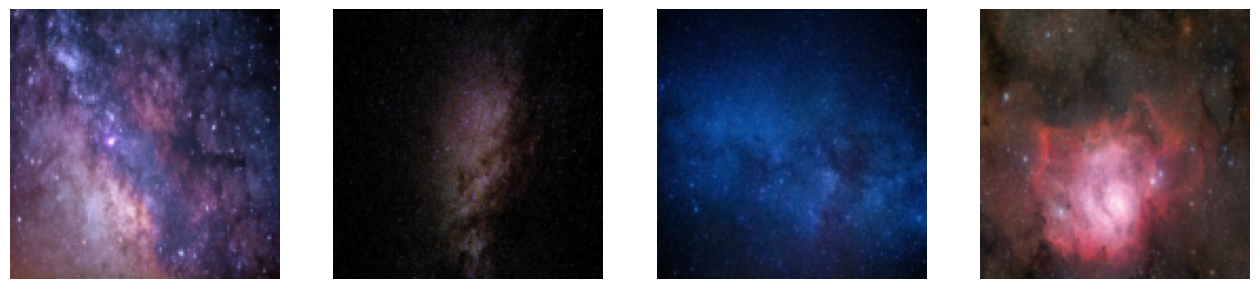

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [19]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [20]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [21]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


In [22]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [23]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# 이미지를 PIL 이미지 객체로 변환하여 시각화
pil_image = Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
pil_image.show()


In [24]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [26]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [27]:
from diffusers import DDPMPipeline
import os
import math

# 이미지들을 그리드 형태로 합치는 함수
def make_grid(images, rows, cols, target_size=(1200, 700)):
    w, h = images[0].size
    grid_width = cols * target_size[0]
    grid_height = rows * target_size[1]
    grid = Image.new('RGB', size=(grid_width, grid_height))
    
    for i, image in enumerate(images):
        image = image.resize(target_size, Image.ANTIALIAS)  # 이미지 크기 조정
        grid.paste(image, box=(i%cols*target_size[0], i//cols*target_size[1]))
    
    return grid

# 평가 함수
def evaluate(config, epoch, pipeline):
    # 무작위 노이즈에서 일부 이미지 샘플링 (역방향 확산 과정)
    # 기본적으로 파이프라인 출력 유형은 `List[PIL.Image]`입니다.
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # 이미지를 그리드 형태로 합치기
    image_grid = make_grid(images, rows=1, cols=1)

    # 이미지 저장
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


In [28]:
import torch
from torch.utils.tensorboard import SummaryWriter

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    if accelerator.is_local_main_process:
        # Set up tensorboard writer
        log_dir = "./logs"  # Change this path to your desired directory
        writer = SummaryWriter(log_dir=log_dir)

    # Rest of the code remains the same

    # Now you train the model
    for epoch in range(config.num_epochs):
        # ... rest of your training loop ...

        if accelerator.is_local_main_process:
            # Log metrics to tensorboard
            writer.add_scalar("Loss/Train", loss.item(), global_step=global_step)
            writer.add_scalar("LR", lr_scheduler.get_last_lr()[0], global_step=global_step)

    if accelerator.is_local_main_process:
        # Close the tensorboard writer at the end
        writer.close()

    # Rest of the code remains the same


In [29]:
# ! pip install numpy --upgrade
# ! pip freeze | % {$_ -replace '==', '>='} | pip install -U -r /dev/stdin


In [30]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

# 모델 아이디와 조직명(선택적)을 사용하여 전체 레포 이름을 생성하는 함수
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

# 훈련 루프 함수
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # 가속화 및 텐서보드 로깅 초기화
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps
    )
    if accelerator.is_local_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # 모든 준비 작업 수행
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # 모델 훈련
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # 각 에포크 후에 평가와 모델 저장
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)


In [31]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


d:\fipro\ddpm-butterflies-128 is already a clone of https://huggingface.co/kiyuyeon/ddpm-butterflies-128. Make sure you pull the latest changes with `repo.git_pull()`.


  0%|          | 0/60 [00:00<?, ?it/s]

c:\Users\chwo6\AppData\Local\anaconda3\envs\py3.8\lib\site-packages\diffusers\configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\chwo6\AppData\Local\Temp\ipykernel_5660\1890801843.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)  # 이미지 크기 조정


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0000.png', 'samples/0004.png', 'samples/0014.png', 'samples/0024.png', 'samples/0034.png', 'samples/0039.png']. This may take a bit of time if the files are large.
Several commits (14) will be pushed upstream.
The progress bars may be unreliable.
batch response: Authorization error.
error: failed to push some refs to 'https://huggingface.co/kiyuyeon/ddpm-butterflies-128'



OSError: batch response: Authorization error.
error: failed to push some refs to 'https://huggingface.co/kiyuyeon/ddpm-butterflies-128'


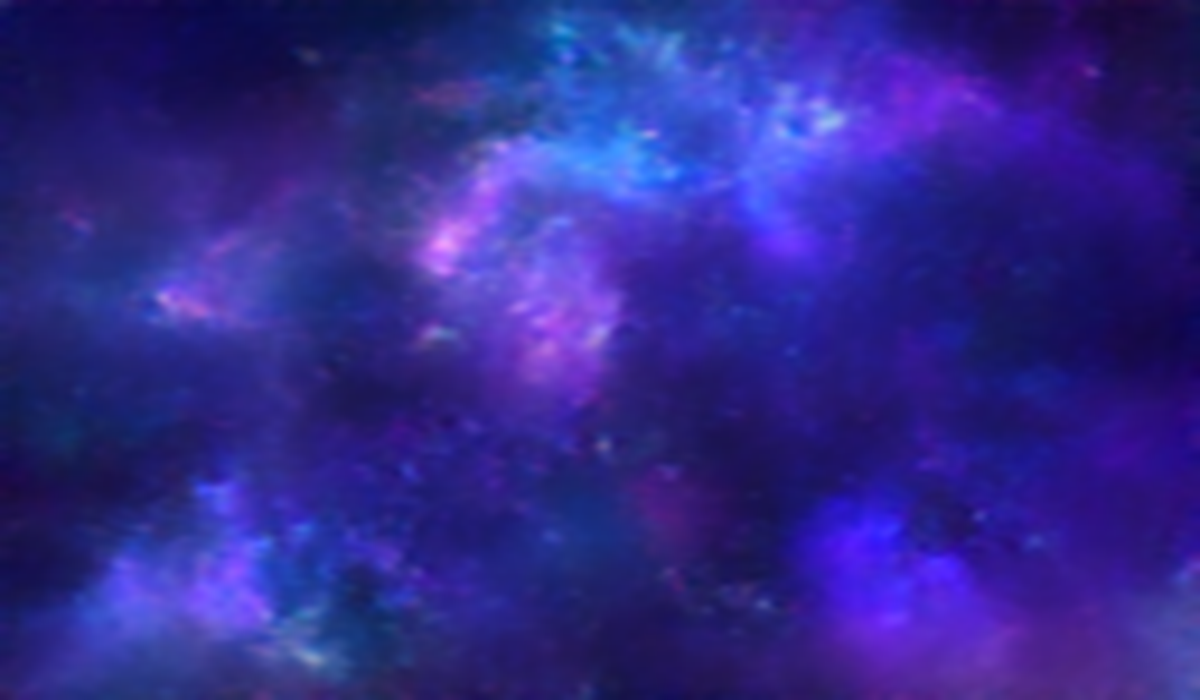

In [32]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])